# CIBMTR - Equity in post-HCT Survival Predictions

This is my approach to the Kaggle competition hosted by CIBMTR.  
An overview of the challenge can be found [here](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview).

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
sns.set(style="whitegrid")
%matplotlib inline

## Data Exploration

We see that there are 28,800 and 3 subjects in the train and test datasets, respectively.

In [3]:
# Import train and test CSV files
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (28800, 60)
Test shape: (3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [5]:
# Columns not present in test set 
set(train.columns) - set(test.columns)

{'efs', 'efs_time'}

In [6]:
# Summarise the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [7]:
# Data types in the training dataset
train.dtypes.value_counts()

object     35
float64    23
int64       2
Name: count, dtype: int64

In [8]:
# Create a dictionary of the features and their categories 
not_features = ['ID', 'efs', 'efs_time']

features = {
    'all' : [col for col in train.columns if col not in not_features],
    'categorical' : [],
    'continuous' : [],
}

for col in features['all']:
    if train[col].dtype in ['object']:
        features['categorical'].append(col)
    elif train[col].dtype in ['int64', 'float64']:
        features['continuous'].append(col)
    
    # Debugging step
    else:
        print(f"Feature was not categorised: {col}")

print(f"There are {len(features['all'])} features in the data, {len(features['categorical'])} categorical and {len(features['continuous'])} continuous. \n")
print(f"Categorical features:\n{features['categorical']} \n")
print(f"Continuous features:\n{features['continuous']}")

There are 57 features in the data, 35 categorical and 22 continuous. 

Categorical features:
['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate'] 

Continuous features:
['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla

### Missing Data

Most variables have a high proportion of missing values. The only variables with no missing values are `ID`, `tbi_status`, `graft_type`, `prim_disease_hct`, `prod_type`, `year_hct`, `age_at_hct`, `race_group`, `efs`, and `efs_time`.

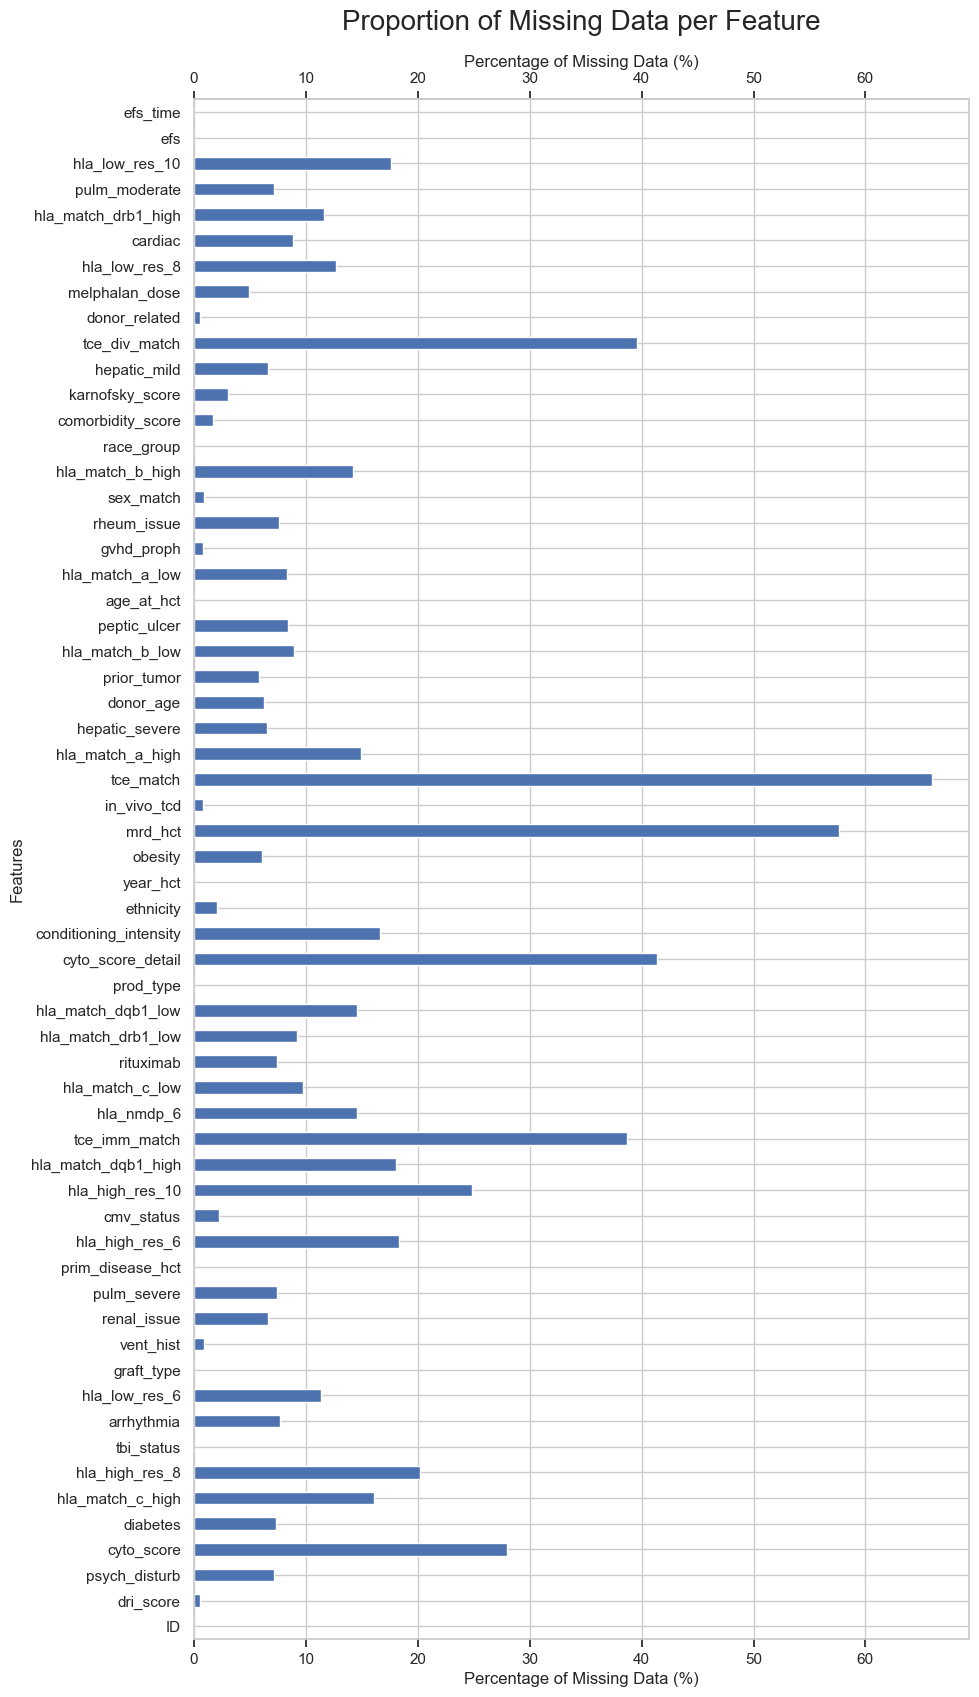

In [9]:
# Calculate percentage missingness
missing_percent = (train.isnull().sum() / len(train)) * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 20))
missing_percent.plot(kind='barh', ax=ax)

# Set labels and title
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Features')
plt.title('Proportion of Missing Data per Feature', fontsize = 20, pad = 50)

# Add x-axis to the top
ax_top = ax.secondary_xaxis('top')
ax_top.set_xlabel('Percentage of Missing Data (%)')

# Add x-axis ticks to the bottom
ax.xaxis.tick_bottom()

## Preprocessing

We will perform various preprocessing operations on the data:
* Missing values in categorical features will be filled with `'NA'`.
* Label encode categorical features to `int64` and then convert to the more memory efficient `category` type.
* Reduce precision of continuous features from 64-bit to 32-bit to save memory.

In [10]:
## PREPROCESSING FUNCTIONS

# Fill missing categorical features with 'NA'
def fill_missing_cat_data(df):
    for col in features['categorical']:
        df[col] = df[col].fillna('NA')
    return df

# Label encode categorical features 
le_dict = {}
def label_encode_cat_data(df, le_dict=le_dict):
    for col in features['categorical']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        df[col] = df[col].astype('category')
        le_dict[col] = le
    return df

# Reduce precision of continuous features
def reduce_precision(df):
    for col in features['continuous']:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

In [11]:
# Combine the train and test data for preprocessing 
combined = pd.concat([train, test], axis=0, ignore_index=True)

In [12]:
pre_processing = [
    fill_missing_cat_data, 
    label_encode_cat_data,   # Reduces memory by 51% 
    reduce_precision         # Reduces memory by 21%
]
for func in pre_processing:
    combined = func(combined)

In [13]:
# Calculate memory usage for combined dataset 
mem = combined.memory_usage().sum() / 1024**2
print(f'Memory usage: {mem:.2f} MB\n')

Memory usage: 4.05 MB



In [14]:
# Split the train and test data following preprocessing
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

## Random Survival Forest

### Hyperparameter Tuning

In [15]:
# Suppress parrallel worker warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='joblib.externals.loky.process_executor')

In [16]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

CPUS = -1
SEED = 42

train_dev = train.sample(n=2000, random_state=SEED)

# Convert to a structured array for survival data
survival_data = Surv.from_dataframe(event='efs', time='efs_time', data=train_dev)

# Prepare features and target
X = train_dev.drop(['ID', 'efs', 'efs_time'], axis=1)
y = survival_data

# Define the model
model = RandomSurvivalForest(
    # n_estimators=100, 
    n_jobs=CPUS,
    random_state=SEED
)

# Define parameter distribution for random search
param_dist = {
    "n_estimators": randint(50, 200),       # Number of trees
    "max_depth": randint(3, 20),            # Maximum depth of trees
    "min_samples_split": randint(2, 20),    # Minimum samples to split a node
    "min_samples_leaf": randint(1, 10),     # Minimum samples per leaf
    "max_features": ["sqrt", "log2", None]  # Number of features to consider for best split
}

# Tune hyperparameters using random search 
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  
    n_jobs=CPUS,  
    cv=5,  
    random_state=SEED
)

# Fit the model
random_search.fit(X, y)

# View the best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 120}
Best Score: 0.6446711706805723
CPU times: user 5.99 s, sys: 692 ms, total: 6.68 s
Wall time: 5min 9s


### Model Fitting

In [17]:
%%time

CPUS = -1
SEED = 42
FOLDS = 5

train_dev = train.copy()

# Convert to a structured array for survival data
survival_data = Surv.from_dataframe(event='efs', time='efs_time', data=train_dev)

# Prepare features and target
X = train_dev[features['all']]
y = survival_data

# Set up K-Fold Cross-Validation  
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Variable for storing results
fold_results = np.zeros(FOLDS)
oof_pred = np.zeros(len(train_dev))

for fold, (train_index, valid_index) in enumerate(cv.split(X)):
    # Split data for current fold
    X_train = X.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_train = y[train_index]
    y_valid = y[valid_index]

    # Fit model  
    model = RandomSurvivalForest(
        n_estimators=120,
        min_samples_split=14,
        min_samples_leaf=4,
        max_features="sqrt",
        max_depth=13,
        n_jobs = CPUS,
        random_state=SEED
    )
    model.fit(X_train, y_train)

    # Evaluate the model using the concordance index
    c_index = model.score(X_valid, y_valid)
    print(f'Fold {fold + 1} - Concordance index: {c_index:.4f}')
    fold_results[fold] = c_index

    # Record OOF predictions
    oof_pred[valid_index] = model.predict(X_valid)

c_index_average = sum(fold_results)/len(fold_results)
print(f'\nAverage Concordance Index Across Folds: sum {c_index_average:.4f}\n')

Fold 1 - Concordance index: 0.6643
Fold 2 - Concordance index: 0.6670
Fold 3 - Concordance index: 0.6663
Fold 4 - Concordance index: 0.6571
Fold 5 - Concordance index: 0.6544

Average Concordance Index Across Folds: sum 0.6618

CPU times: user 44min 18s, sys: 18min 32s, total: 1h 2min 50s
Wall time: 12min 59s


In [18]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group'], observed=False).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [19]:
# Evaluate model
y_true = train_dev[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_dev[["ID"]].copy()
y_pred["prediction"] = oof_pred
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Random Survival Forest =",m)


Overall CV for Random Survival Forest = 0.6510312786397916
